# Sentence Embeddings for Image Captions
In this Jupyter notebook we will derive the word embeddings, in form of BERT embeddings, from our generated image captions. For this, we will first read in the data as csv file, tokenize the data, and then feed into a pre-trained BERT model to derive the sentence-level embeddings (= CLS token). To evaluate the results, we will implement a function to search for a specific sequence, and thus a specific image, in the dataset.

# 1. Load necessary libraries

In [ ]:
# If needed
!pip install seqeval
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install sentence-transformers

In [1]:
# import necessary libraries for neural network(s) 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel

# For analysis and displaying process
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

Using TensorFlow backend.


In [11]:
# Use GPU backend if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if str(device) == "cuda":
    torch.cuda.get_device_name(0)
    print("device is GPU")

else:
    print("device is CPU")

device is CPU


# 2. Data Pre-Processing
Our generated image caption-dataset is pretty straightforward. We have saved all captions into a .csv file in the format (caption, image_id). We simply need to read in the data, e.g. using pandas csv-reader, and then pre-process the sentences using standard BERT pre-processing. As we don't have to further fine-tune the BERT model, we also do not need to read in the data using a DataLoader for Batch processing or generate attention masks.

In [2]:
import os
import pandas as pd

class DataPreprocess(object):

    
    def __init__(self, captions, image_ids, csv_data):
        
        # Training and test data
        self.captions = captions
        self.image_ids = image_ids
        self.csv_data = csv_data
        
        self.args = ''
        
        
    @classmethod
    def ProcessData(cls, args):
        '''
        This is the main method in the DataPreprocess-class. Call this function to instantiate the class and
        to preprocess the dataset. It comprises:
        - loading of the data (LoadDataHD())
        - prepare data by adding 'CLS' and 'SEP' tokens (PrepareData())
        - splitting the sentences into subwords using the WordPiece tokenizer and ge IDs (BertTokenization()) 
        
        Return: x_train, slots_train, intents_train, x_test, slots_test, intents_test, train_dataloader, validation_dataloader to class
        '''
        
        cls.args = args
        
        # Call LoadData()-method to load data from hard drive or Google Cloud
        csv_data = DataPreprocess.LoadDataHD(cls)
         
        # Load the raw_captions and the image ids into separate numpy arrays
        raw_captions, image_ids = DataPreprocess.ConvertQueries(csv_data)
        
        # Tokenize the captions with the BERT tokenizer    
        captions = DataPreprocess.BertTokenization(raw_captions, args)
        
        return cls(captions, image_ids, csv_data)
        
        
    @staticmethod
    def LoadDataHD(self):
    
        # Define the paths for the .csv file
        csv_path = self.args.dir_path + '/captions.csv'
    
        # Import .csv file using pandas
        csv = pd.read_csv(csv_path)
    
        return csv
    
    
    @staticmethod
    def ConvertQueries(data):
    
        # Retrieve tokenized raw_captions and image_ids as numpy array
        raw_captions = data['caption'].values
        image_ids = data['thumbnail_id'].values

        return raw_captions, image_ids
    
    
    
    '''
    This method processes the captions. For every caption in the dataset
    we will firts remove the BOS and EOS tokens, and then split each word into its BERT-subwords. 
    Then, we tokenize the BERT subwords, add paddings and return the tokenized captions.
    '''
    @staticmethod
    def BertTokenization(data, args):
        
        captions = list()
        
        # First, remove the [BOS] and [EOS] tokens and replace them with [CLS] and [SEP]
        for caption in data:
            
            caption = caption.replace('[BOS]','[CLS]')
            caption = caption.replace('[EOS]','[SEP]')
            captions.append(caption)
        
        # Second, instantiate the BERT tokenizer and load captions
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
        tokenized_sentences = [tokenizer.tokenize(sentences) for sentences in captions]

        # Use BERT Tokenizer to convert subword tokens into indexes
        input_ids = [tokenizer.convert_tokens_to_ids(subwords) for subwords in tokenized_sentences]

        # Pad input tokens to a maximum of 128 characters
        input_ids = pad_sequences(input_ids, maxlen=args.max_seq_len, dtype="long", truncating="post", padding="post")
        
        # Transform input IDs to tensors
        input_ids = torch.tensor(input_ids)
        
        return input_ids
    

## 3. Retrieving sentence embeddings and compute similarities
We will try different ways to compute meaningful sentence embeddings. One way is to compute BERT sentence embeddings, the other way is to compute sentence embeddings using Siamese BERT-Networks (https://www.aclweb.org/anthology/D19-1410.pdf). For the latter approach, we do not need to derive BERT tokens, but simply read in the captions from the csv-file in raw format (without [BOS] and [EOS] tokens).

### 3.1 BERT sentence embeddings
We'll use HuggingFaces pre-trained BERT models for pytorch in a very simple setup. As we do not fine-tune the BERT model, we will simply load the pre-trained model and insert our tokenized captions for inference.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel

def GetEmbeddings_BERT(data, args):
    
    model = args.model_bert
    model = model.to(device)

    embeddings = list()
    
    for caption in data:
        
        output = model(caption.unsqueeze(0))
        pooled_output = output[1]
        embeddings.append(pooled_output)
        
    return embeddings

In [5]:
import scipy

def FindSimiliarities_BERT(caption_embeddings, captions, ids, args, number_top_matches = 5):
    
    query = input("Enter query here: ")
    org_query = query
    
    # Process and tokenize query
    query = ["[CLS] " + query + " [SEP]"]
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
    tokenized_sentences = [tokenizer.tokenize(sentences) for sentences in query]
    input_ids = [tokenizer.convert_tokens_to_ids(subwords) for subwords in tokenized_sentences]
    input_ids = pad_sequences(input_ids, maxlen=args.max_seq_len, dtype="long", truncating="post", padding="post")
    input_ids = torch.tensor(input_ids)
    
    # Load BertModel and get embedding for the query
    output = args.model_bert(input_ids)
    query_embedding = output[1]
    
    # Save distances into array
    distances = list()
    
    # Get the distances for the query
    for idx, caption in enumerate(caption_embeddings):
        
        distance = scipy.spatial.distance.cdist(caption.detach().numpy(), query_embedding.detach().numpy(), "cosine")[0]
        distances.append(distance)
    
    # Combine cosine distances and ids using zip (change to ids later!!!)
    results = zip(captions, distances)
    results = sorted(results, key = lambda x: x[1])
    
    print("\n\n======================\n\n")
    print("Query:", org_query)
    print("\nTop most similar sentences in corpus:")
    
    for idx, distance in results[0:number_top_matches]:
        print(idx, "(Cosine Score: %.4f)" % (1-distance))

### 3.2 Siamese BERT-Networks sentence embeddings
Alternatively, we will derive the sentence embeddings using Siamese BERT-Networks. 

In [3]:
# When using the Sentence Transformer, we will send the raw sentence without [BOS] or [EOS] tags
def GetEmbeddings_SiameseBERT(data, args):
    
    raw_captions = list()
    
    for caption in data:
        caption = caption.replace('[BOS] ','')
        caption = caption.replace(' [EOS]','')
        raw_captions.append(caption)
    
    model = args.model_sentence
    model = model.to(device)

    embeddings = model.encode(raw_captions)
        
    return embeddings

In [4]:
import scipy
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

def FindSimiliarities_SiameseBERT(caption_embeddings, captions, ids, args, number_top_matches = 50):
    
    query = str(input("Enter query here: "))
    query = [query]
    org_query = query
    
    # Get embedding of the query using SiameseBERT Networks
    
    model = args.model_sentence
    model = model.to(device)

    query_embedding = model.encode(query)
    #query_embedding = np.expand_dims(query_embedding[0], axis=0)
    
    
    # Save distances into array
    distances = list()
    
    # Get the distances for the query
    for idx, caption in enumerate(caption_embeddings):
        
        caption = np.expand_dims(caption, axis=0)
        
        distance = scipy.spatial.distance.cdist(caption, query_embedding, "cosine")
        distances.append(distance)
    
    # Combine cosine distances and ids using zip (change to ids later!!!)
    results = zip(captions, ids, distances)
    results = sorted(results, key = lambda x: x[2])
    
    # Display results
    print("\n\n======================\n\n")
    print("Query:", org_query)
    print("\nTop most similar sentences in corpus:")
    
    img_to_print = list()
    
    # Define image grid for showing corresponding images
    fig = plt.figure(figsize=(100., 100.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(25, 2),  # creates 2x8 grid of axes
                 axes_pad=1.3,  # pad between axes in inch.
                 )
    i = 0
    for caption, idx, distance in results[0:number_top_matches]:
        
        print(caption, idx,  "(Cosine Score: %.4f)" % (1-distance))
        grid[i].imshow(Image.open(args.img_path + idx).convert('RGB'))
        grid[i].set_title(idx + '\n' + caption[5: (len(caption)-5)])
        i+=1

    plt.show()

# 4. Run everything
Now, it's time to run everything. We will start by instantiating the arguments class, which hold all parameters and pre-loads our models. Then, we will call the DataPreprocess class to tokenize the captions for reading into our BERT-model. Next, we compute the sentence embeddings using the BERT and SiameseBERT models. After, we will derive the cosine similarities for the captions.

In [5]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel
from sentence_transformers import SentenceTransformer

class Arguments(object):
    
    def __init__(self):
        
        self.max_seq_len = 128                # Maximum sentence length     
        self.seed = 42                        # Seed for random initialization
        self.bert_type = 'bert-base-uncased'  # Define BERT model 
        
        # Files and paths
        self.dir_path = os.path.dirname(os.path.realpath('Sentence Embeddings'))
        self.img_path = '/Volumes/Samsung_X5/University/Semesters/Semester 6/Interactive Video Retrieval/thumbnails/'
        
        # Model
        self.model_bert = BertModel.from_pretrained('bert-base-uncased')
        self.model_sentence = SentenceTransformer('bert-base-nli-mean-tokens')
        
        
        

In [6]:
# Instantiate Arguments class
args = Arguments()

In [7]:
# Instantiate DataPreprocess class to tokenize the captions
data_object = DataPreprocess.ProcessData(args)

In [8]:
# Get raw_captions from the data object for the Siamese BERT-networks
captions_raw = data_object.csv_data['caption'].tolist()

In [9]:
# Get subdata for test purposes
subdata = data_object.captions[:10]
sub_captions = data_object.csv_data['caption'].values[:10]
sub_captions_raw = captions_raw[:10]
sub_ids = data_object.csv_data['thumbnail_id'].values[:10]

In [199]:
# Get the sentence embeddings using BERT
subdata_embeddings_BERT = GetEmbeddings_BERT(subdata, args)

In [12]:
# Get the sentence embeddings using the Siamese BERT-networks (takes about 25min for 60.000 captions)
embeddings_SiameseBERT = GetEmbeddings_SiameseBERT(captions_raw, args)

KeyboardInterrupt: 

In [13]:
# Save the sentence embeddings using pickle
path_save = args.dir_path + '/embeddings_captions.pkl'
        
with open(path_save, 'wb') as f:
    pickle.dump(embeddings_SiameseBERT, f)

NameError: name 'embeddings_SiameseBERT' is not defined

## 5. Evaluation of the Results
Finally, we can evaluate the results. We will compare the results of the original BERT model with the Siamese-BERT networks. As you can see, the Siamese-BERT Network are better suited to derive sentence embeddings as the original BERT model. 

In [224]:
# Find similarities for the BERT embeddings
FindSimiliarities_BERT(subdata_embeddings_BERT, sub_captions, sub_ids, args)

Enter query here: a woman




Query: a woman

Top most similar sentences in corpus:
[BOS] a man in a striped shirt is holding a [UNK] [EOS] (Cosine Score: 0.9847)
[BOS] a television screen showing a news screen [EOS] (Cosine Score: 0.9785)
[BOS] a man brushing his teeth with a toothbrush [EOS] (Cosine Score: 0.9753)
[BOS] a person in a dark jacket holding a black cat [EOS] (Cosine Score: 0.9747)
[BOS] a picture of a man standing on a road [EOS] (Cosine Score: 0.9703)


In [15]:
# Load caption embeddings using pickle
embeddings_path = args.dir_path + '/caption_embeddings 2.pkl'
file = open(embeddings_path, 'rb')
caption_embeddings = pickle.load(file)

Enter query here: a man on a bike in the streets




Query: ['a man on a bike in the streets']

Top most similar sentences in corpus:
[BOS] a man riding a bike on a street [EOS] 02741_26.jpg (Cosine Score: 0.9754)
[BOS] a man is riding a bike in the street [EOS] 03670_60.jpg (Cosine Score: 0.9737)
[BOS] a man riding a bike down a street next to a person [EOS] 00343_39.jpg (Cosine Score: 0.9676)
[BOS] a man riding a bike down a street next to a person [EOS] 06949_104.jpg (Cosine Score: 0.9676)
[BOS] a man riding a bike down a street next to a person [EOS] 02941_32.jpg (Cosine Score: 0.9676)
[BOS] a man riding a bike on a street with a person on a bike [EOS] 05625_38.jpg (Cosine Score: 0.9636)
[BOS] a man riding a bike down a street next to a bike [EOS] 02941_29.jpg (Cosine Score: 0.9633)
[BOS] a man riding a bike down a street [EOS] 03670_54.jpg (Cosine Score: 0.9630)
[BOS] a man riding a bike down a street [EOS] 05772_118.jpg (Cosine Score: 0.9630)
[BOS] a man riding a bike down a stre

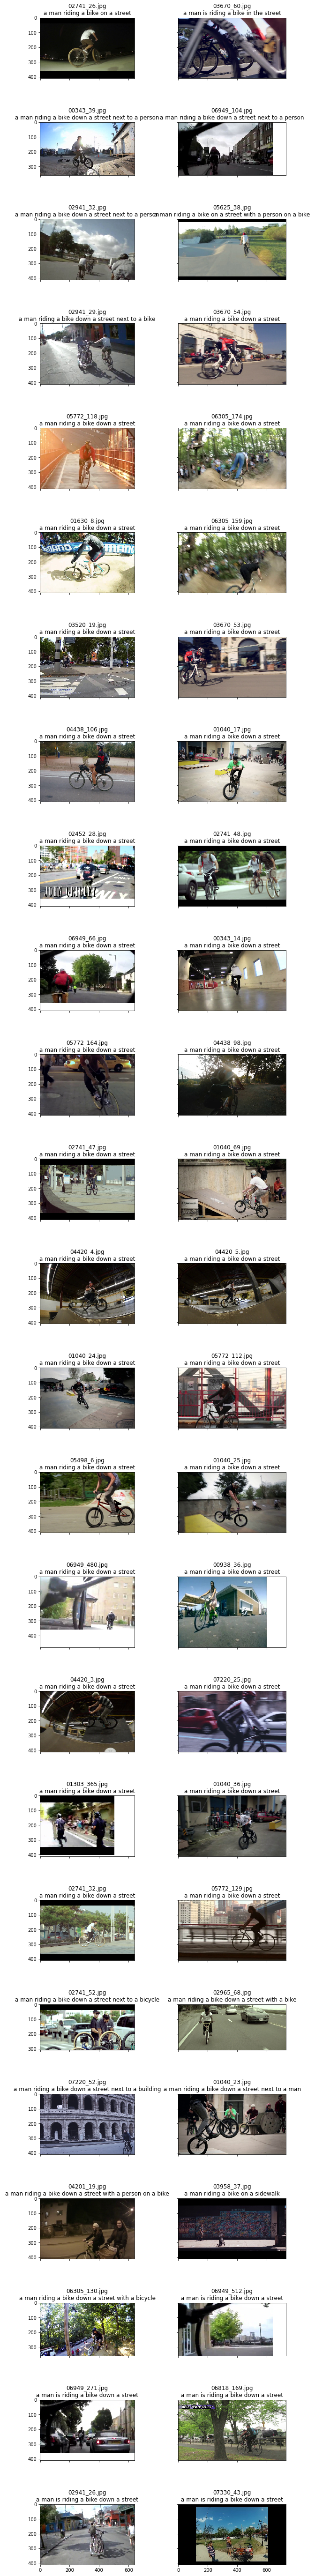

In [16]:
# Find similarities for the Siamese BERT embeddings
FindSimiliarities_SiameseBERT(caption_embeddings, 
                              data_object.csv_data['caption'].values, 
                              data_object.csv_data['thumbnail_id'].values, 
                              args)

## 6. Code for the Interactive Video Retrieval Pipeline
Below is the code for our Interactive Video Retrieval Pipeline.

In [306]:
'''
FindSimiliarities(data, args):
--> input-format
    - query:                is the search query. Must be a list in the following format
                            -> query = ['your query is here']
    - caption_embeddings:   are the preprocessed caption-embeddings, which need to be loaded
    - captions, img_ids:    are the original captions and image_ids from captions.csv
                            -> should be handed to the function as lists with the values
    - model:                pass the pre-loaded model, i.e. the SentenceTransformer to the function
    - number_top_matches:   defines the how many best-matches are returned
    
--> returns
    - best_matches:         are the top-n matches in the format (img_ids, cosine_similarities)
    - results:              are all images and their corresponding cosine_similiarities sorted by
                            the highest cosine similarities

'''
import scipy
import numpy as np

def FindSimiliarities(query, caption_embeddings, captions, img_ids, model, number_top_matches = 16):
    
    #query = [query]
    
    # Get the embedding of the query using SiameseBERT Networks
    model = model
    query_embedding = model.encode(query)
    
    # Get the distances for the query and save them into distances
    distances = list()
    
    for idx, caption in enumerate(caption_embeddings):
        
        caption = np.expand_dims(caption, axis=0)
        distance = scipy.spatial.distance.cdist(caption, query_embedding, "cosine")
        distances.append(distance)
        
    # Combine cosine distances and ids using zip (change to ids later!!!)
    results = zip(captions, img_ids, distances)
    results = sorted(results, key = lambda x: x[2])
    
    # Retrieve best_matching results
    best_matches = list()
    
    for caption, idx, distance in results[0:number_top_matches]:
        best_matches.append([idx, (1-distance)])
        
    return best_matches, results

In [307]:
from sentence_transformers import SentenceTransformer
import os
import pickle
import pandas as pd

# Load Model
embedding_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Load caption embeddings using pickle
embeddings_path = args.dir_path + '/caption_embeddings.pkl'
file = open(embeddings_path, 'rb')
caption_embeddings = pickle.load(file)
file.close()

# Load the caption and img_ids from the captions.csv file
csv_path = args.dir_path + '/captions.csv'
csv = pd.read_csv(csv_path)
captions = csv['caption'].tolist()
img_ids = csv['thumbnail_id'].tolist()

# Define the query
query = ['a group of people']

# Get the best matching captions
best_matches, results = FindSimiliarities(query, 
                                         caption_embeddings,
                                         captions,
                                         img_ids,
                                         embedding_model
                                         )

print(best_matches)
        

[['06606_88.jpg', array([[0.92248778]])], ['05018_32.jpg', array([[0.84031854]])], ['02801_27.jpg', array([[0.81586563]])], ['05497_76.jpg', array([[0.81481161]])], ['06801_9.jpg', array([[0.81481161]])], ['03722_74.jpg', array([[0.81460111]])], ['02422_61.jpg', array([[0.81460111]])], ['01219_97.jpg', array([[0.79351034]])], ['07000_136.jpg', array([[0.79351034]])], ['05400_71.jpg', array([[0.79351034]])], ['02745_161.jpg', array([[0.79351034]])], ['05751_90.jpg', array([[0.79351034]])], ['02102_135.jpg', array([[0.78155053]])], ['04024_0.jpg', array([[0.7737099]])], ['01727_147.jpg', array([[0.7737099]])], ['02694_21.jpg', array([[0.77008348]])]]
